In [1]:
# import the serious stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

/home/aswin/project/book_id/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# create random images
no_of_images = 50000
image_size = 8
min_object_size = 1
max_object_size = 4
no_of_objects = 2 # number of squares in an image

# stores list of boundary of every object
bounding_boxes = np.zeros((no_of_images, no_of_objects, 4))

# list of images
images = np.zeros((no_of_images, image_size, image_size))

for i_image in range(no_of_images):
    for i_object in range(no_of_objects):
        # size is the no of random variables to be generated
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, image_size - w)
        y = np.random.randint(0, image_size - h)
        images[i_image, x:x+w, y:y+h] = 1.
        bounding_boxes[i_image, i_object] = [x, y, w, h]

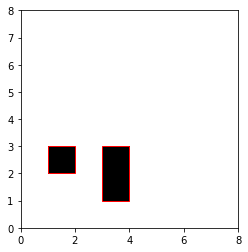

In [3]:
# debug
# .T does diagonal transform
plt.imshow(images[0].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
for bounding_box in bounding_boxes[0]:
    # apparently draws bounding boxes
    plt.gca().add_patch(matplotlib.patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2], bounding_box[3], ec='r', fc='none'))

In [4]:
# normalize data to mean 0 and std 1, -1 means dimension is unknown
X = (images.reshape(no_of_images, -1) - np.mean(images) / np.std(images))
print(X.shape, np.mean(X), np.std(X))

# normalize x, y, w, h by image_size, so all values are between 0 and 1
y = bounding_boxes.reshape(no_of_images, -1) / image_size
print(y.shape, np.mean(y), np.std(y))

(50000, 64) -0.24861344865437146 0.3239285591748915
(50000, 8) 0.28143 0.17502088832479396


In [5]:
# split training and test dataset
split = int(0.8 * no_of_images)
train_X = X[:split]
test_X = X[split:]
train_y = y[:split]
test_y = y[split:]

# test images
test_images = images[split:]
test_boxes = bounding_boxes[split:]

In [6]:
# build the model
model = Sequential([
    Dense(200, input_dim=X.shape[-1]),
    Activation('relu'),
    Dropout(0.2),
    Dense(y.shape[-1])
])
model.compile('adadelta', 'mse')

In [7]:
# train the model
model.fit(train_X, train_y, epochs=30, validation_data=(test_X, test_y), verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
 - 2s - loss: 0.0235 - val_loss: 0.0182
Epoch 2/30
 - 2s - loss: 0.0187 - val_loss: 0.0174
Epoch 3/30
 - 2s - loss: 0.0179 - val_loss: 0.0171
Epoch 4/30
 - 2s - loss: 0.0176 - val_loss: 0.0167
Epoch 5/30
 - 2s - loss: 0.0173 - val_loss: 0.0165
Epoch 6/30
 - 2s - loss: 0.0171 - val_loss: 0.0164
Epoch 7/30
 - 2s - loss: 0.0169 - val_loss: 0.0163
Epoch 8/30
 - 2s - loss: 0.0168 - val_loss: 0.0162
Epoch 9/30
 - 2s - loss: 0.0167 - val_loss: 0.0162
Epoch 10/30
 - 2s - loss: 0.0166 - val_loss: 0.0161
Epoch 11/30
 - 2s - loss: 0.0165 - val_loss: 0.0160
Epoch 12/30
 - 2s - loss: 0.0165 - val_loss: 0.0160
Epoch 13/30
 - 2s - loss: 0.0164 - val_loss: 0.0160
Epoch 14/30
 - 2s - loss: 0.0164 - val_loss: 0.0160
Epoch 15/30
 - 2s - loss: 0.0164 - val_loss: 0.0159
Epoch 16/30
 - 2s - loss: 0.0163 - val_loss: 0.0159
Epoch 17/30
 - 2s - loss: 0.0163 - val_loss: 0.0159
Epoch 18/30
 - 2s - loss: 0.0162 - val_loss: 0.0159
Epoch 19/30
 - 2s - los

In [8]:
# predict bounding boxes for test data
predicted_y = model.predict(test_X)
predicted_boxes = predicted_y * image_size
predicted_boxes = predicted_boxes.reshape(len(predicted_boxes), no_of_objects, -1)
predicted_boxes.shape

(10000, 2, 4)

In [9]:
# calculate overlap between two bounding boxes
def IOU(box_1, box_2):
    x1, y1, w1, h1 = box_1[0], box_1[1], box_1[2], box_1[3]
    x2, y2, w2, h2 = box_2[0], box_2[1], box_2[2], box_2[3]
    
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    
    if w_I <= 0 or h_I <= 0: # no overlap
        return 0
    
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    
    return I/U

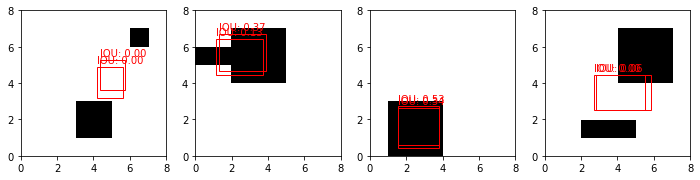

In [10]:
# draw sample predictions
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_images))
    plt.imshow(test_images[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
    
    for predicted_box, expected_box in zip(predicted_boxes[i], test_boxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((predicted_box[0], predicted_box[1]), predicted_box[2], predicted_box[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(predicted_box, expected_box)), (predicted_box[0], predicted_box[1] + predicted_box[3] + 0.2), color='r')

In [11]:
# mean IOU
summed_IOU = 0
for predicted_box, test_box in zip(predicted_boxes.reshape(-1, 4), test_boxes.reshape(-1, 4)):
    summed_IOU += IOU(predicted_box, test_box)

mean_IOU = summed_IOU / len(predicted_boxes)
print(mean_IOU)

0.33042827129327323
